In [1]:
from glob import glob

import numpy as np
from tqdm import tqdm

import g2s
from g2s.graph_extractor import xyz2mol_graph
from g2s.representations.locality import get_local_environment, construct_sparse_dm

In [2]:
ci_path = sorted(glob('/data/lemm/g2s/const_isomers/*.xyz'))

In [3]:
def prep_data(filepath):
    bond_order_matrix, nuclear_charges, coords = xyz2mol_graph(filepath)

    distances = g2s.utils.calculate_distances(coords)
    gc = g2s.GraphCompound(bond_order_matrix, nuclear_charges, distances)
    gc.generate_bond_length(size=19, sorting='norm_row')

    representation = gc.representation
    adjacency = gc.adjacency_matrix
    nuclear_charges = gc.nuclear_charges
    distances = gc.distances

    representation = g2s.utils.vector_to_square([representation])[0]
    distances = g2s.utils.vector_to_square([distances])[0]

    hydrogen_idxs = np.where(nuclear_charges == 1)[0]
    heavy_atom_idxs = np.where(nuclear_charges != 1)[0]

    ha_representation = representation[heavy_atom_idxs][:, heavy_atom_idxs]
    hy_representation = representation[hydrogen_idxs][:, heavy_atom_idxs]

    ha_dm = distances[heavy_atom_idxs][:, heavy_atom_idxs]
    ha_nc = nuclear_charges[heavy_atom_idxs]

    ha_local_repr = []
    ha_local_nc = []
    ha_local_dist = []
    ha_local_idxs = []

    hy_local_repr = []
    hy_local_nc = []
    hy_local_dist = []
    hy_local_idxs = []

    for i in range(len(heavy_atom_idxs)):
        atomic_representation, local_nuclear_charges, local_idxs, local_distances = get_local_environment(i, ha_representation, ha_nc, ha_dm, n_neighs=3)
        ha_local_repr.append(atomic_representation)
        ha_local_dist.append(local_distances)
        ha_local_nc.append(local_nuclear_charges)
        ha_local_idxs.append(local_idxs)

    for i in hydrogen_idxs:
        hydro_atomic_representation, hydro_local_nuclear_charges, hydro_local_idxs, hydro_local_distances = get_local_environment(i, representation, nuclear_charges, distances, n_neighs=4)
        hy_local_repr.append(hydro_atomic_representation)
        hy_local_nc.append(hydro_local_nuclear_charges)
        hy_local_dist.append(hydro_local_distances)
        hy_local_idxs.append(hydro_local_idxs)
        
    mol_data = {'ha_lr': ha_local_repr,
                'ha_lnc': ha_local_nc,
                'ha_ldist': ha_local_dist,
                'ha_lidxs': ha_local_idxs,
                'hy_lr': hy_local_repr,
                'hy_lnc': hy_local_nc,
                'hy_ldist': hy_local_dist,
                'hy_lidxs': hy_local_idxs,
                'nuclear_charges': nuclear_charges,
                'heavy_atom_idxs': heavy_atom_idxs,
                'hydrogen_idxs': hydrogen_idxs,
                'full_dm': distances}
   
    return mol_data

def get_unique_environments(local_environments, local_idxs, local_distances=None):
    uq_env = {}
    for i, r in enumerate(local_environments):
        if tuple(r) not in uq_env.keys():
            uq_env[tuple(r)] = {'local_idxs': [],
                                'local_dist': []}
        uq_env[tuple(r)]['local_idxs'].append(local_idxs[i])
        if local_distances is not None:
            uq_env[tuple(r)]['local_dist'].append(local_distances[i])

    if local_distances is not None:

        for k in uq_env.keys():
            uq_env[k]['avg_dist'] = np.array(uq_env[k]['local_dist']).mean(axis=0)
    return uq_env

    

In [4]:
mol_envs = []

for ci in tqdm(ci_path):
    mol_envs.append(prep_data(ci))

100%|██████████| 6095/6095 [00:22<00:00, 274.45it/s]


In [5]:
ha_lr = [mol_envs[i]['ha_lr'] for i in range(len(mol_envs))]
hy_lr = [mol_envs[i]['hy_lr'] for i in range(len(mol_envs))]
ha_lidxs = [mol_envs[i]['ha_lidxs'] for i in range(len(mol_envs))]
hy_lidxs = [mol_envs[i]['hy_lidxs'] for i in range(len(mol_envs))]
ha_ldist = [mol_envs[i]['ha_ldist'] for i in range(len(mol_envs))]
hy_ldist = [mol_envs[i]['hy_ldist'] for i in range(len(mol_envs))]

In [6]:
uq_ha_env = get_unique_environments(np.vstack(ha_lr), np.vstack(ha_lidxs), local_distances=np.vstack(ha_ldist))
uq_hy_env = get_unique_environments(np.vstack(hy_lr), np.vstack(hy_lidxs), local_distances=np.vstack(hy_ldist))

In [7]:
training_ha_envs = []
training_ha_labels = []

training_hy_envs = []
training_hy_labels = []

for k in uq_ha_env.keys():
    training_ha_envs.append(k)
    training_ha_labels.append(uq_ha_env[k]['avg_dist'])
    

for k in uq_hy_env.keys():
    training_hy_envs.append(k)
    training_hy_labels.append(uq_hy_env[k]['avg_dist'])
    
training_ha_envs = np.array(training_ha_envs)
training_ha_labels = np.array(training_ha_labels)
training_hy_envs = np.array(training_hy_envs)
training_hy_labels = np.array(training_hy_labels)

In [71]:
kernel_sigma = 32
kernel_lambda = 1e-5

train_kernel = g2s.krr.laplacian_kernel(training_envs, training_envs, 32)
train_kernel[np.diag_indices_from(train_kernel)] += 1e-5
alphas = g2s.krr.train_multikernel(train_kernel, training_labels)

pred_distances = g2s.krr.predict_distances(train_kernel, alphas)

100%|██████████| 6/6 [00:00<00:00, 8968.58it/s]


In [98]:
stdev = []

for k in uq_ha_env.keys():
    stdev.append(np.array(uq_ha_env[k]['local_dist']).std(axis=0))

In [101]:
np.array(stdev).shape

(57, 6)

In [103]:
import matplotlib.pyplot as plt
%matplotlib inline

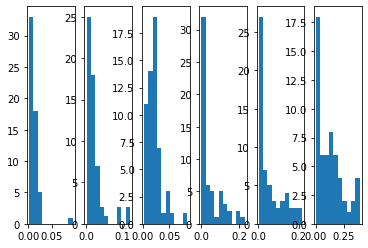

In [108]:
fig, axs = plt.subplots(1, 6)
for i in range(6):
    axs[i].hist(np.array(stdev)[:, i])
plt.show()

In [85]:
def local_env_lookup(uq_ha_env, uq_hy_env, mol):
    ha_lr, hy_lr, heavy_atom_idxs = mol['ha_lr'],  mol['hy_lr'], mol['heavy_atom_idxs']
    ha_local_idxs, hy_local_idxs = mol['ha_lidxs'], mol['hy_lidxs']
    n_total_atoms, n_heavy_atoms = len(mol['nuclear_charges']), len(heavy_atom_idxs)
    ha_dists = []
    hy_dists = []
    for i in range(len(ha_lr)):
        ha_dists.append(uq_ha_env[tuple(ha_lr[i])]['avg_dist'])
    for i in range(len(hy_lr)):
        hy_dists.append(uq_hy_env[tuple(hy_lr[i])]['avg_dist'])
    
    sparse_dm = construct_sparse_dm(np.array(ha_dists), ha_local_idxs, n_atoms=n_heavy_atoms, n_neighs=4)
#     hy_sparse_dm = construct_sparse_dm(np.array(hy_dists), hy_local_idxs, n_atoms=n_total_atoms, n_neighs=5)
#     for j, e in enumerate(heavy_atom_idxs):
#         for k, em in enumerate(heavy_atom_idxs):
#             hy_sparse_dm[e, em] = sparse_dm[j, k]
#             hy_sparse_dm[em, e] = sparse_dm[k, j]
    return sparse_dm, mol['nuclear_charges'][heavy_atom_idxs]

In [86]:
sparse_distances = []
mol_nuclear_charges = []
for j in tqdm(range(len(mol_envs))):
    sp, mnc = local_env_lookup(uq_ha_env, uq_hy_env, mol_envs[j])
    sparse_distances.append(sp)
    mol_nuclear_charges.append(mnc)

100%|██████████| 6095/6095 [00:03<00:00, 1779.81it/s]


In [83]:
np.array(sparse_distances).shape

(6095, 9, 9)

In [87]:
np.array(mol_nuclear_charges).shape

(6095, 9)

In [88]:
dgsol = DGSOL(np.array(sparse_distances),   np.array(mol_nuclear_charges), vectorized_input=False)
dgsol.solve_distance_geometry('./test_const_iso_heavy', n_solutions=50)

100%|██████████| 6095/6095 [53:57<00:00,  1.88it/s]  


In [101]:
np.where(dgsol.c_errors[:,0,0] > 1.)

(array([2211]),)

In [102]:
dgsol.c_errors[2211,0,0]

6.4

In [99]:
dirs = sorted(glob('./test_const_iso_heavy/*'))
for i, e in enumerate(dirs):
    for j in range(2):
        g2s.utils.write_xyz(f'{e}/ci-{i:04d}_conf-{j:02d}.xyz', dgsol.coords[i][j], dgsol.nuclear_charges[i])

In [69]:
dgsol.gen_cerror_overview()

Error Type, Min, Mean, Max
minError: 0.0, 12080331776.0, 144999991738368.0
avgError: 0.0, 15345688576.0, 15500000100352.0
maxError: 0.0, 32060172288.0, 45800000323584.0


In [29]:
np.abs(sparse_distances[0] - mol_envs[0]['full_dm']).max()

6.657596808989

In [66]:
import os
import subprocess

import numpy as np
from tqdm import tqdm

from g2s.utils import vector_to_square


class DGSOL:
    """
    Wrapper class for the Distance Geometry Solver (DGSOL)

    Embeds points in cartesian space given a distance boundary.

    To read more about DGSOl visit: https://www.mcs.anl.gov/~more/dgsol/
    """
    def __init__(self, distances, nuclear_charges, vectorized_input=True):
        """

        Parameters
        ----------
        distances: np.array
            Either a symmetric (n, n) distance matrix or its vectorized form.
        nuclear_charges: np.array, shape n
            Nucelear charges of the system
        vectorized_input: bool (default=True)
            Whether the distance matrix is in its vectorized form or not.
            If True, converts distance matrix to its symmetric form.
        """
        self.nuclear_charges = nuclear_charges
        self.distances = vector_to_square(distances) if vectorized_input else distances
        self.coords = None
        self.c_errors = None

    def gen_cerror_overview(self):
        """
        Prints overview of DGSOl reconstruction errors
        """
        print('Error Type, Min, Mean, Max')
        print(f'minError: {np.min(self.c_errors[:, 1])}, {np.mean(self.c_errors[:, 1])}, {np.max(self.c_errors[:, 1])}')
        print(f'avgError: {np.min(self.c_errors[:, 2])}, {np.mean(self.c_errors[:, 2])}, {np.max(self.c_errors[:, 2])}')
        print(f'maxError: {np.min(self.c_errors[:, 2])}, {np.mean(self.c_errors[:, 3])}, {np.max(self.c_errors[:, 3])}')

    def to_scientific_notation(self, number):
        """
        Converts numbers to DGSOL notation.

        Parameters
        ----------
        number: float

        Returns
        -------
        Number in DGSOL notation, e.g. 1e10
        """
        a, b = '{:.17E}'.format(number).split('E')
        num = '{:.12f}E{:+03d}'.format(float(a) / 10, int(b) + 1)
        return num[1:]

    def write_dgsol_input(self, distances, outpath):
        """
        Input file writer for DGSOL.
        Basically writes 4 columns such as
        Atom_i   Atom_j  lower_bound       upper_bound
        1         2   .139169904722E+01   .139169904722E+01
        1         3   .237179033727E+01   .237179033727E+01
        1         4   .331764447534E+01   .331764447534E+01
        1         5   .200997900174E+01   .200997900174E+01

        Parameters
        ----------
        distances: np.array
            Vectorized distance matrix.
        outpath: str
            Directory to save input file

        """
        n, m = np.triu_indices(distances.shape[1], k=1)
        with open(f'{outpath}/dgsol.input', 'w') as outfile:
            for i, j in zip(n, m):
                upper = distances[i, j]
                lower = distances[i, j]
                if distances[i, j] == 0.0:
                    upper = 20.
                    lower = 1.0
                outfile.write(
                    f'{i + 1:9.0f}{j + 1:10.0f}   {self.to_scientific_notation(lower)}   '
                    f'{self.to_scientific_notation(upper)}\n')

    def parse_dgsol_coords(self, path, n_solutions, n_atoms):
        """
        Parser for DGSOl output file.
        Reads all found solutions and filters coordinates.

        Parameters
        ----------
        path: str
            Path to dgsol.output file.
        n_solutions: int
            Number of dgsol solutions.
        n_atoms: int
            Number of atoms.

        Returns
        -------
        coords: np.array, shape (n, 3)
            Coordinates of the system.

        """
        with open(f'{path}/dgsol.output') as outfile:
            lines = outfile.readlines()

        coords = []
        for line in lines:
            if not line.startswith('\n') and len(line) > 30:
                coords.append([float(n) for n in line.split()])
        coords = np.array(coords).reshape((n_solutions, n_atoms, 3))
        return coords

    def solve_distance_geometry(self, outpath, n_solutions=10):
        """
        Interface to solve distance geometry problem.
        Writes input for DGSOL, run's DGSOL and parses coordinates.

        Parameters
        ----------
        outpath: str
            Output directory to write input files and run DGSOL.
        n_solutions: int (default=10)
            Number of solutions to compute with DGSOL.

        """
        construction_errors = []
        mol_coordinates = []
        mol_ids = np.arange(self.distances.shape[0])
        for i, ids in tqdm(enumerate(mol_ids), total=len(mol_ids)):
            out = f'{outpath}/{ids:04}'
            os.makedirs(out, exist_ok=True)
            self.write_dgsol_input(distances=self.distances[i], outpath=out)
            self.run_dgsol(out, n_solutions=n_solutions)
            errors = self.parse_dgsol_errors(out)
            lowest_errors_idx = np.argsort(errors[:, 2])
            construction_errors.append(errors[lowest_errors_idx])
            coords = self.parse_dgsol_coords(out, n_solutions, n_atoms=len(self.nuclear_charges[i]))
            mol_coordinates.append(coords[lowest_errors_idx])
        self.coords = np.array(mol_coordinates, dtype=object)
        self.c_errors = np.array(construction_errors)

    def run_dgsol(self, outpath, n_solutions=10):
        """
        Interface to submit DGSOL as a subprocess.

        Parameters
        ----------
        outpath: str
            Output directory to write input files and run DGSOL.
        n_solutions: int (default=10)
            Number of solutions to compute with DGSOL.

        """
        # 
        cmd = f'mpirun -np 24 dgsol -s{n_solutions} {outpath}/dgsol.input {outpath}/dgsol.output {outpath}/dgsol.summary'
        process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
        output, error = process.communicate()
        if error is not None:
            raise UserWarning(f'{outpath} produced the following error: {error}')

    def parse_dgsol_errors(self, outpath):
        """
        Parses DGSOL Errors.

        There are 4 types of errors in the dgsol output:

        f_err         The value of the merit function
        derr_min      The smallest error in the distances
        derr_avg      The average error in the distances
        derr_max      The largest error in the distances

        Parameters
        ----------
        outpath: str
            Output directory that contains dgsol.summary

        Returns
        -------
        dgsol_erros: np.array
            Contains DGSOL errors, shape(4)

        """
        with open(f'{outpath}/dgsol.summary', 'r') as input:
            lines = input.readlines()

        errors = []
        # skip the header lines
        for line in lines[5:]:
            errors.append(line.split()[2:])   # the first two entries are n_atoms and n_distances
        return np.array(errors).astype('float32')

In [65]:
dgsol = g2s.dgeom.DGSOL(np.array(sparse_distances)[:1],   np.array(mol_nuclear_charges)[:1], vectorized_input=False)
dgsol.solve_distance_geometry('./test', n_solutions=100)

  0%|          | 0/1 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: './test/0000/dgsol.summary'

In [64]:
pwd

'/home/lem/github/Graph2Structure/examples'

In [52]:
for j in range(3):
    g2s.utils.write_xyz(f'./test/ci-{i:04d}_conf-{j:02d}.xyz', dgsol.coords[0][j], dgsol.nuclear_charges[0])